# Imports and Functions

In [15]:
import numpy as np
import time
from joblib import Parallel, delayed
import matplotlib.pyplot as plt

import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from lib.renormalization_np import track_rg_flow


def analyze_coefficients_vs_M_parallel(M_values, J=0.0, n_max=20, n_steps=50, b=2, d=2, n_workers=None):
    """
    Analyze coefficient behavior when varying M with fixed J value.
    
    Args:
        M_values: Array of M values to analyze
        J: Fixed J value to use (default 0.0 to look for M-based fixed-line behavior)
        n_max: Maximum Fourier mode
        n_steps: Number of RG steps
        b: Length rescaling factor
        d: Dimension
        n_workers: Number of workers for parallelization (default: None = auto)
    
    Returns:
        Dictionary with coefficient data
    """
    def process_single_M(M):
        """Process a single M value"""
        # Track the RG flow
        flow_history = track_rg_flow(J, J, M, b, d, n_max, n_steps)
        
        # Extract final coefficients
        final_coeffs = flow_history[-1]
        
        # Store key coefficients (real parts)
        coeffs = np.zeros(7)
        coeffs[0] = final_coeffs[n_max, n_max].real       # (0,0)
        coeffs[1] = final_coeffs[n_max+1, n_max].real     # (1,0)
        coeffs[2] = final_coeffs[n_max, n_max+1].real     # (0,1)
        coeffs[3] = final_coeffs[n_max+1, n_max+1].real   # (1,1)
        coeffs[4] = final_coeffs[n_max+2, n_max].real     # (2,0)
        coeffs[5] = final_coeffs[n_max, n_max+2].real     # (0,2)
        coeffs[6] = final_coeffs[n_max+2, n_max+2].real   # (2,2)
        
        # Calculate key ratios
        ratios = np.zeros(6)
        if abs(coeffs[0]) > 1e-10:
            ratios[0] = coeffs[1] / coeffs[0]  # (1,0)/(0,0)
            ratios[1] = coeffs[2] / coeffs[0]  # (0,1)/(0,0)
            ratios[2] = coeffs[3] / coeffs[0]  # (1,1)/(0,0)
            ratios[3] = coeffs[4] / coeffs[0]  # (2,0)/(0,0)
            ratios[4] = coeffs[5] / coeffs[0]  # (0,2)/(0,0)
            ratios[5] = coeffs[6] / coeffs[0]  # (2,2)/(0,0)
        
        # Calculate deviation from the M-based Villain-like form
        deviation = np.nan
        
        # Use (1,1) and (2,2) coefficients to estimate M_v parameter
        if abs(coeffs[3]) > 1e-10 and abs(coeffs[6]) > 1e-10:
            ratio_11_22 = abs(coeffs[6] / coeffs[3])  # |(2,2)/(1,1)|
            
            if ratio_11_22 < 1:  # Normal decay pattern
                M_v = -6 / (4 * np.log(ratio_11_22))  # Adjusted formula for M-based model
                
                # Calculate expected values for M-based Villain-like model
                expected = np.zeros(7)
                
                # Normalization coefficient
                expected[0] = 1.0  # (0,0) normalized
                
                # Calculate other coefficients using the derived formula
                # For M-dependence: λ_{nm} ∝ exp(-(n²+m²)/(4M_v))
                expected[1] = np.exp(-1/(4*M_v))  # (1,0)
                expected[2] = np.exp(-1/(4*M_v))  # (0,1)
                expected[3] = np.exp(-2/(4*M_v))  # (1,1)
                expected[4] = np.exp(-4/(4*M_v))  # (2,0)
                expected[5] = np.exp(-4/(4*M_v))  # (0,2)
                expected[6] = np.exp(-8/(4*M_v))  # (2,2)
                
                # Apply sign correction for negative M
                if M < 0:
                    for i in range(1, 7):
                        n, m = int(coeff_labels[i][1]), int(coeff_labels[i][3])
                        if (n + m) % 2 == 1:  # Odd n+m
                            expected[i] *= -1
                
                # Calculate deviation
                squared_diff = 0
                for j in range(7):
                    if abs(coeffs[0]) > 1e-10:
                        norm_coeff = coeffs[j] / coeffs[0]
                        norm_expected = expected[j]
                        squared_diff += (norm_coeff - norm_expected)**2
                
                deviation = np.sqrt(squared_diff)
                
                return coeffs, ratios, deviation, M_v
            else:
                return coeffs, ratios, np.nan, np.nan
        else:
            return coeffs, ratios, np.nan, np.nan
    
    # Initialize arrays
    n_coeffs = 7
    coefficients = np.zeros((len(M_values), n_coeffs))
    ratios = np.zeros((len(M_values), 6))
    deviations = np.zeros(len(M_values))
    M_v_values = np.zeros(len(M_values))
    
    # Set up the number of workers
    if n_workers is None:
        try:
            import psutil
            n_workers = psutil.cpu_count(logical=False)
            if n_workers is None:
                n_workers = max(1, (psutil.cpu_count() or 4) // 2)
        except ImportError:
            import multiprocessing as mp
            n_workers = max(1, mp.cpu_count() // 2)
    
    # Process M values in parallel with joblib
    coeff_labels = ['(0,0)', '(1,0)', '(0,1)', '(1,1)', '(2,0)', '(0,2)', '(2,2)']
    print(f"Processing {len(M_values)} M values using {n_workers} workers...")
    start_time = time.time()
    
    results = Parallel(n_jobs=n_workers, verbose=10)(
        delayed(process_single_M)(M) for M in M_values
    )
    
    elapsed = time.time() - start_time
    print(f"Processing complete! Elapsed time: {elapsed:.1f}s")
    
    # Unpack results
    for i, result in enumerate(results):
        if len(result) == 4:
            coeffs, rats, dev, m_v = result
            coefficients[i] = coeffs
            ratios[i] = rats
            deviations[i] = dev
            M_v_values[i] = m_v
    
    # Return results dictionary
    return {
        'M_values': M_values,
        'J': J,
        'coefficients': coefficients,
        'ratios': ratios,
        'deviations': deviations,
        'M_v_values': M_v_values,
        'coeff_labels': coeff_labels,
        'ratio_labels': ['(1,0)/(0,0)', '(0,1)/(0,0)', '(1,1)/(0,0)', 
                         '(2,0)/(0,0)', '(0,2)/(0,0)', '(2,2)/(0,0)']
    }

In [45]:
def plot_m_villain_comparison(results, coeffs_to_show=None, figsize=(12, 8)):
    """
    Plot coefficients and their M-based Villain-like form predictions versus M values.
    
    Args:
        results: Results dictionary from analyze_coefficients_vs_M_parallel
        coeffs_to_show: List of coefficient labels to display (e.g., ['(1,0)', '(1,1)'])
                        If None, shows all coefficients
        figsize: Figure size tuple (default: (12, 8))
        
    Returns:
        Matplotlib figure
    """
    M_values = results['M_values']
    J = results['J']
    coefficients = results['coefficients']
    coeff_labels = results['coeff_labels']
    M_v_values = results['M_v_values']
    
    # Define which coefficients to show
    if coeffs_to_show is None:
        # Show all except (0,0) which is always 1 when normalized
        coeffs_to_show = coeff_labels[1:]
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Calculate normalized coefficients
    norm_coeffs = np.zeros_like(coefficients)
    for i in range(len(M_values)):
        if abs(coefficients[i, 0]) > 1e-10:
            norm_coeffs[i] = coefficients[i] / coefficients[i, 0]
        else:
            norm_coeffs[i] = np.zeros_like(coefficients[i])
    
    # Calculate Villain-like form predictions
    villain_coeffs = np.zeros((len(M_values), len(coeff_labels)))
    villain_coeffs[:, 0] = 1.0  # (0,0) is always 1 when normalized
    
    # Coefficient indices mapping from label to array index
    coeff_indices = {label: idx for idx, label in enumerate(coeff_labels)}
    
    # Define coefficient parameters for M-based Villain form
    # For M-dependence model: λ_{nm} ∝ exp(-(n²+m²)/(4M_v))
    exponents = {
        '(0,0)': 0,
        '(1,0)': 1,
        '(0,1)': 1,
        '(1,1)': 2,
        '(2,0)': 4,
        '(0,2)': 4,
        '(2,2)': 8
    }
    
    # Calculate Villain-like predictions for all coefficients
    for i in range(len(M_values)):
        if not np.isnan(M_v_values[i]) and M_v_values[i] != 0:
            for label, exp in exponents.items():
                idx = coeff_indices[label]
                # Use the derived formula for M-based model
                villain_coeffs[i, idx] = np.exp(-exp/(4*abs(M_v_values[i])))
                
                # Apply sign correction based on M sign and coefficient
                n, m = map(int, [label[1], label[3]])
                if M_values[i] < 0 and (n + m) % 2 == 1:
                    # For odd n+m, flip sign for M < 0
                    villain_coeffs[i, idx] *= -1
    
    # Colors for different coefficients
    colors = {
        '(1,0)': 'blue',
        '(0,1)': 'green',
        '(1,1)': 'red',
        '(2,0)': 'purple',
        '(0,2)': 'brown',
        '(2,2)': 'teal'
    }
    
    # Markers for different coefficients
    markers = {
        '(1,0)': 'o',
        '(0,1)': 's',
        '(1,1)': 'd',
        '(2,0)': 'h',
        '(0,2)': 'p',
        '(2,2)': '*'
    }
    
    # Plot normalized coefficients
    for label in coeffs_to_show:
        if label in coeff_indices:
            idx = coeff_indices[label]
            valid = ~np.isnan(norm_coeffs[:, idx])
            if np.any(valid):
                ax.plot(M_values[valid], norm_coeffs[valid, idx], 
                        marker=markers.get(label, 'o'), markersize=8, linestyle='-', linewidth=2, 
                        color=colors.get(label, 'black'), 
                        label=f'$\\lambda_{{{label}}}/\\lambda_{{(0,0)}}$')
    
    # Plot Villain-like predictions
    for label in coeffs_to_show:
        if label in coeff_indices:
            idx = coeff_indices[label]
            valid = ~np.isnan(villain_coeffs[:, idx])
            if np.any(valid):
                ax.plot(M_values[valid], villain_coeffs[valid, idx], 
                        marker='', markersize=0, linestyle='--', linewidth=1, 
                        color='orange', 
                        label=f'Villain $\\lambda_{{{label}}}$')
    
    ax.set_xlabel('Four-spin Interaction $M$', fontsize=14)
    ax.set_ylabel('Normalized Coefficient Value $\\lambda_{(n,m)}/\\lambda_{(0,0)}$', fontsize=14)
    ax.set_title(f'Normalized Fourier Coefficients vs $M$ (J={J})', fontsize=16)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=10, ncol=2)
    fig.tight_layout()
    
    return fig

# Run analysis

Processing 100 M values using 4 workers...


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
100%|██████████| 10/10 [00:33<00:00,  3.32s/it]
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:  1.2min
100%|██████████| 10/10 [00:34<00:00,  3.47s/it]
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  1.8min
100%|██████████| 10/10 [00:40<00:00,  4.03s/it]
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:  3.1min
100%|██████████| 10/10 [00:33<00:00,  3.34s/it]
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  3.7min
100%|██████████| 10/10 [00:32<00:00,  3.29s/it]
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  5.4min
100%|██████████| 10/10 [00:32<00:00,  3.25s/it]
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  6.5min
100%|██████████| 10/10 [00:32<00:00,  3.30s/it]
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:  8.2min
100%|██████████| 10/10 [00:34<00:00,  3.43s/it]
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:  9.5min
100%|██████████| 10/10 [00:28<00:00,  2.83s/it]
[Para

Processing complete! Elapsed time: 845.6s


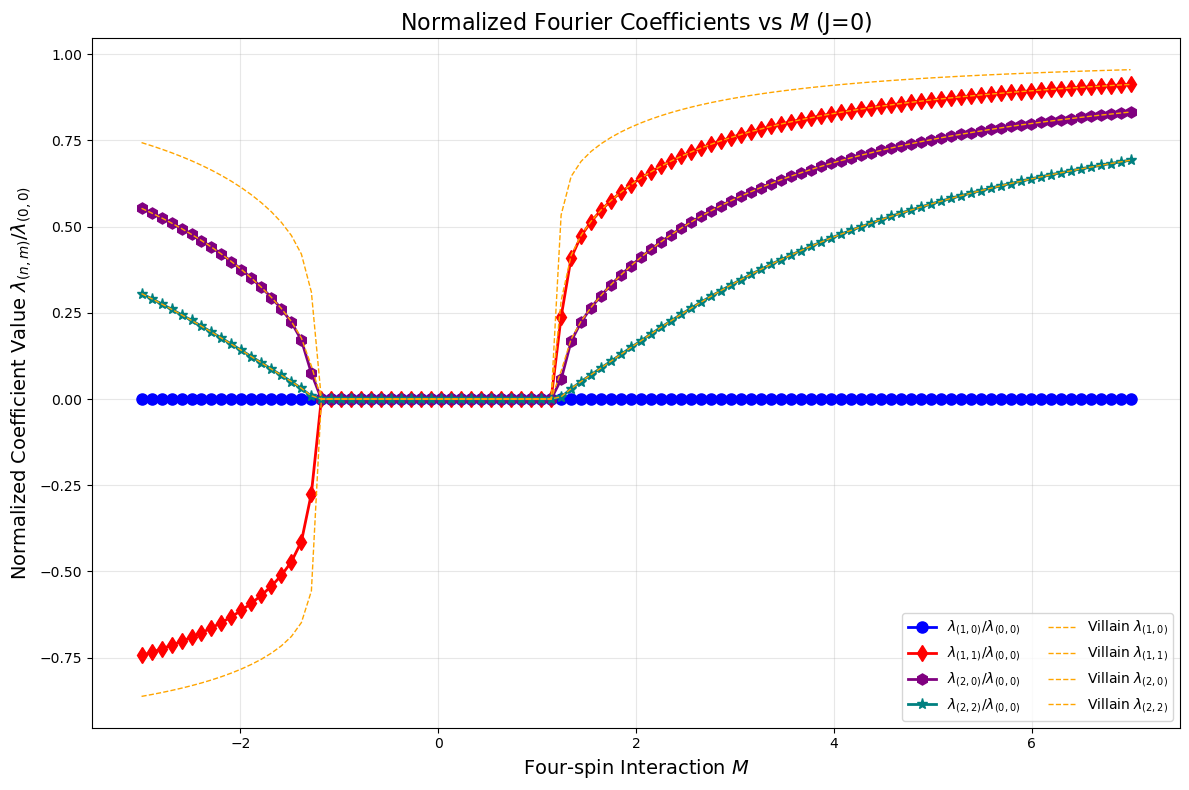

In [49]:
M_values = np.linspace(-3.0, 7.0, 100)

# Run analysis for fixed J
results = analyze_coefficients_vs_M_parallel(M_values, J=0, n_max=20, n_steps=10, b=3, d=2, n_workers=4)

# Plot coefficient comparison with Villain predictions
fig = plot_m_villain_comparison(results, coeffs_to_show=['(1,0)', '(1,1)', '(2,0)', '(2,2)'], figsize=(12, 8))
plt.savefig("fixed-line_fixed-M_o.png", dpi=200)
plt.show()